In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

In [2]:
stock_name = 'Axis Bank'
data = pd.read_csv('BSE_Data/'+stock_name+'.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [3]:
data = data.loc[:,['Date','Open Price', 'High Price', 'Low Price', 'Close Price','No.of Shares']]
data.head()

,Date,Open Price,High Price,Low Price,Close Price,No.of Shares
0,2019-07-31,694.00,695.35,657.65,674.40,1271110
1,2019-07-30,725.05,727.70,701.10,706.55,384131
2,2019-07-29,745.00,745.00,709.90,719.65,328200
3,2019-07-26,723.30,732.30,719.10,729.85,185928
4,2019-07-25,712.00,725.85,706.55,723.30,163417


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2510 entries, 0 to 2509
Data columns (total 6 columns):
Date            2510 non-null datetime64[ns]
Open Price      2510 non-null float64
High Price      2510 non-null float64
Low Price       2510 non-null float64
Close Price     2510 non-null float64
No.of Shares    2510 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 117.7 KB


In [5]:
plot_data = data.copy()
plot_data.head()

,Date,Open Price,High Price,Low Price,Close Price,No.of Shares
0,2019-07-31,694.00,695.35,657.65,674.40,1271110
1,2019-07-30,725.05,727.70,701.10,706.55,384131
2,2019-07-29,745.00,745.00,709.90,719.65,328200
3,2019-07-26,723.30,732.30,719.10,729.85,185928
4,2019-07-25,712.00,725.85,706.55,723.30,163417


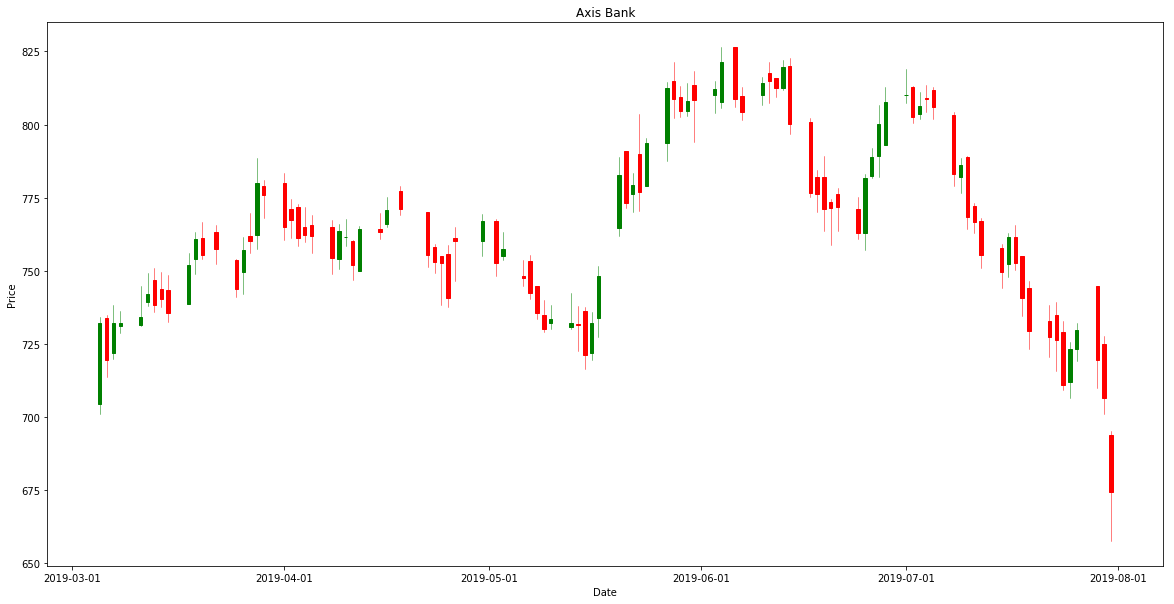

In [6]:
plot_data['Date'] = [mdates.date2num(d) for d in plot_data['Date']]
quotes = plot_data.loc[:100,:].values
fig, ax = plt.subplots(figsize=(20,10))
candlestick_ohlc(ax, quotes, width=0.5, colorup='g', colordown='r');
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(stock_name)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

In [7]:
monthly_data = data.copy()
monthly_data.set_index(monthly_data["Date"],inplace=True)
monthly_data['Open Price'] = monthly_data['Open Price'].resample('M', how='first')
monthly_data['High Price'] = monthly_data['High Price'].resample('M', how='max')
monthly_data['Low Price'] = monthly_data['Low Price'].resample('M', how='min')
monthly_data['Close Price'] = monthly_data['Close Price'].resample('M', how='last')
monthly_data['No.of Shares'] = monthly_data['No.of Shares'].resample('M', how='sum')
monthly_data = monthly_data.dropna()
monthly_data.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  import sys


,Date,Open Price,High Price,Low Price,Close Price,No.of Shares
Date,,,,,,
2019-07-31,2019-07-31,810.00,819.05,657.65,674.40,7234390.0
2019-05-31,2019-05-31,766.90,821.40,716.40,808.50,9641183.0
2019-04-30,2019-04-30,779.95,783.55,737.60,766.90,7332259.0
2019-02-28,2019-02-28,721.00,734.35,681.20,709.35,11875458.0
2019-01-31,2019-01-31,621.20,726.00,604.65,722.95,16016120.0


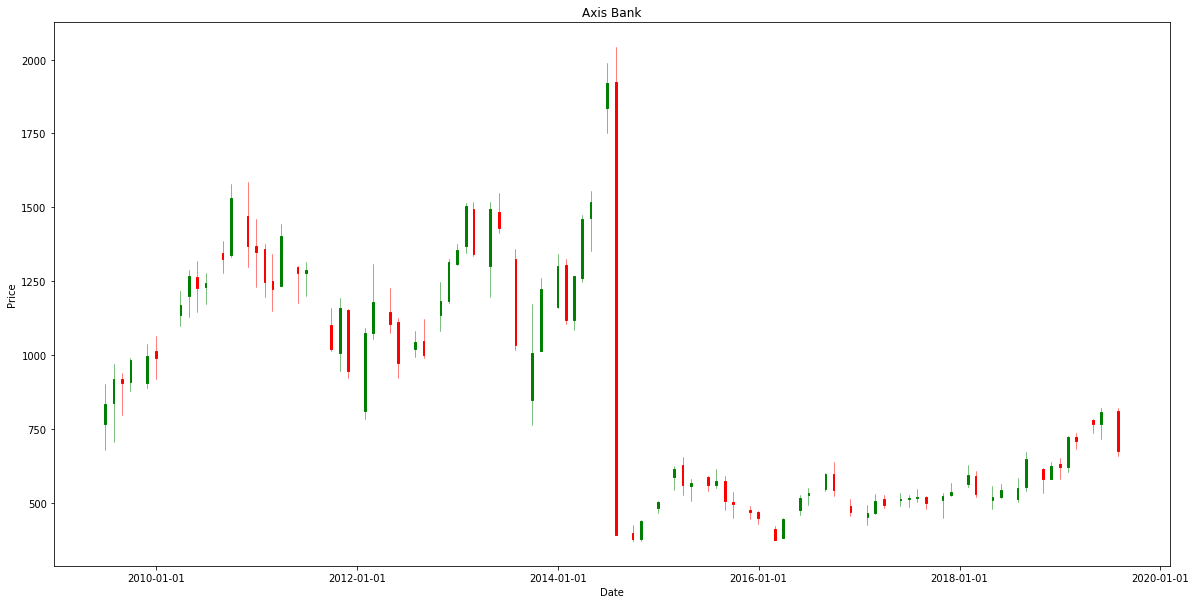

In [8]:
monthly_data = monthly_data.reset_index(drop=True)
monthly_data['Date'] = [mdates.date2num(d) for d in monthly_data['Date']]
quotes = monthly_data.loc[:,:].values
fig, ax = plt.subplots(figsize=(20,10))
candlestick_ohlc(ax, quotes, width=6, colorup='g', colordown='r');
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(stock_name)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

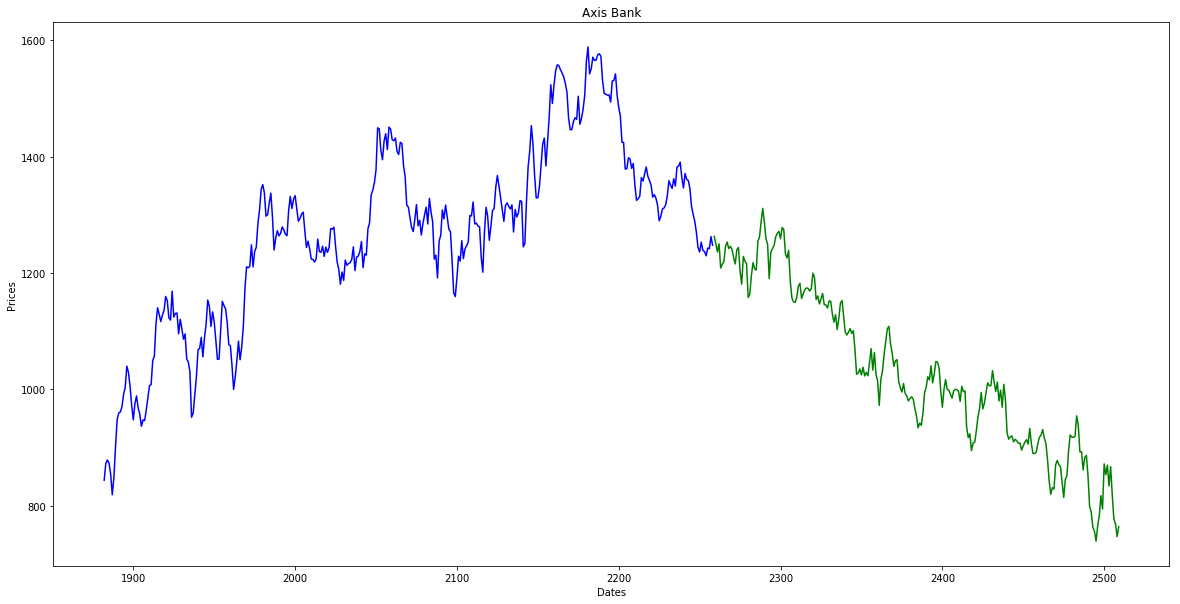

In [57]:
train_data = data[int(len(data)*0.75):int(len(data)*0.9)]
test_data = data[int(len(data)*0.9):]
plt.figure(figsize=(20,10))
plt.title(stock_name)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Close Price'], 'blue', label='Training Data')
plt.plot(test_data['Close Price'], 'green', label='Testing Data')

In [59]:
history = [x for x in train_data['Close Price'].values]
print(type(history))
pred = []
for i in range(len(test_data['Close Price'])):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    pred.append(yhat)
    obs = test_data['Close Price'].values[i]
    history.append(obs)
error = mean_squared_error(test_data['Close Price'].values, pred)
print('Mean Squared Error: ',error)

<class 'list'>
Mean Squared Error:  508.05192776945756


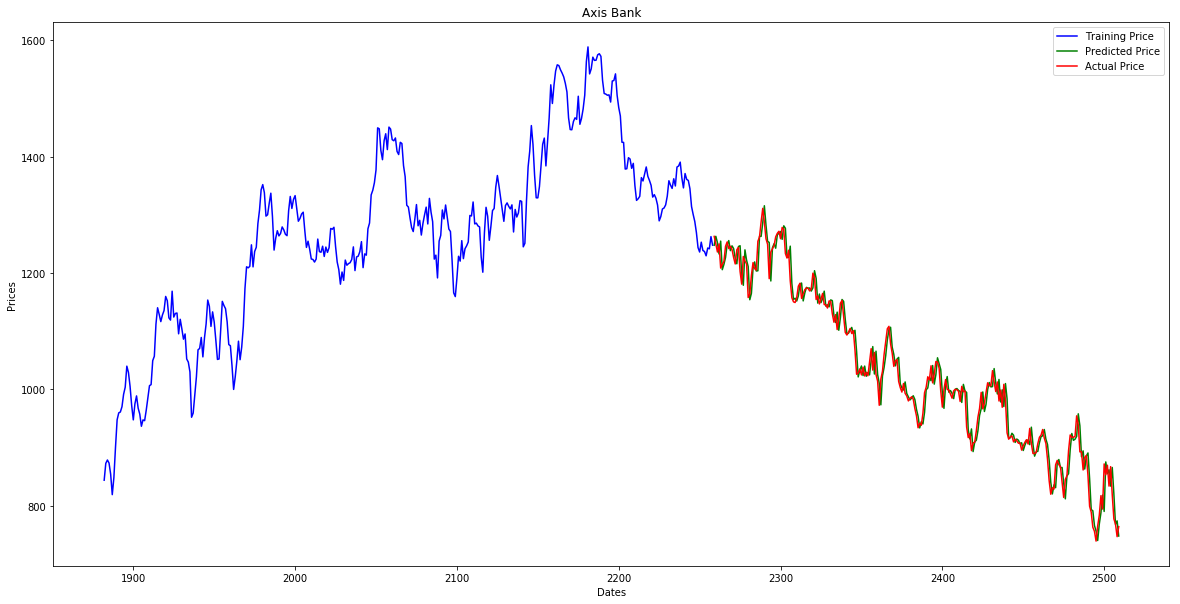

In [62]:
plt.figure(figsize=(20,10))
plt.plot(train_data['Close Price'], 'green', color='blue', label='Training Price')
plt.plot(test_data.index, pred, color='green', label='Predicted Price')
plt.plot(test_data.index, test_data['Close Price'], color='red', label='Actual Price')
plt.title(stock_name)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()